In [2]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(6447)
tf.random.set_seed(6447)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

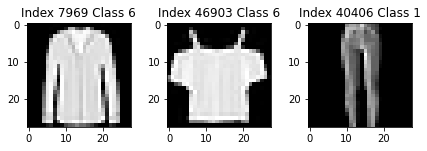

In [4]:
# Load MNIST or FMNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data() 
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [5]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [6]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [7]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [8]:
# Batch Normalization Layer

class BNLayer(keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-8, momentum=0.99):
        super(BNLayer, self).__init__()
        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, is_training):
        """ Ankur Mali's pdf states the formula of BN(x) as:
        IntermediateOP(x) = (x - mean) / sqrt(variance + epsilon)
        BN(x) = gamma * IntermediateOP(x) + beta
        """

        self.it_call += 1

        if is_training: # if is_training == True: The model is in training mode, calculate batch mean and variance 
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            batch_mu = tf.math.reduce_mean(inputs, axis=0)
            batch_var = tf.math.reduce_variance(inputs, axis=0)
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            # update mu and var
            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                # the last batch in training may have sample less than batch size
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_var = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum / self.it_call) + self.mu * (1 - (self.momentum/self.it_call))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum / self.it_call) + self.var * (1 - (self.momentum/self.it_call))
            self.var.assign(cur_var)


        else: # if_training == False. The model is in testing mode, calculate population mean and variance.
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs

**Model 1: Post Activation. Performing Batch Normalization after Activation Function**

In [9]:
# Define class to build mlp model
class MLP(tf.keras.Model):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    super(MLP, self).__init__()
    
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.batchnorm = BNLayer(128)
    self.mlp_variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X, is_training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X, is_training = is_training)
    else:
      self.y = self.compute_output(X, is_training = is_training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

   
 def backward(self, X_train, y_train, optimizer):
    """
    backward pass
    """
    optimizer = optimizer
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.mlp_variables)
    optimizer.apply_gradients(zip(grads, self.mlp_variables))

           
 def compute_output(self, X, is_training):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = self.batchnorm(h1, is_training)

    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = self.batchnorm(h2, is_training)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = self.batchnorm(h3, is_training)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


**Three Runs to check how the accuracy changes in each iteration**

-------------------------- Run: 0 --------------------------------

Train Accuracy: 0.7260
Number of Epoch = 1 - Average Cross Entropy:= 0.0151367626953125 

Validation Accuracy: 0.7234

Train Accuracy: 0.7715
Number of Epoch = 2 - Average Cross Entropy:= 0.0109278466796875 

Validation Accuracy: 0.7713

Train Accuracy: 0.7900
Number of Epoch = 3 - Average Cross Entropy:= 0.008510195922851562 

Validation Accuracy: 0.7891

Train Accuracy: 0.8053
Number of Epoch = 4 - Average Cross Entropy:= 0.007074551391601563 

Validation Accuracy: 0.7986

Train Accuracy: 0.8242
Number of Epoch = 5 - Average Cross Entropy:= 0.0061494805908203125 

Validation Accuracy: 0.8185

Train Accuracy: 0.8420
Number of Epoch = 6 - Average Cross Entropy:= 0.00547492919921875 

Validation Accuracy: 0.8334

Train Accuracy: 0.8534
Number of Epoch = 7 - Average Cross Entropy:= 0.0049401995849609375 

Validation Accuracy: 0.8424

Train Accuracy: 0.8605
Number of Epoch = 8 - Average Cross Entropy:= 0.00451675537109375

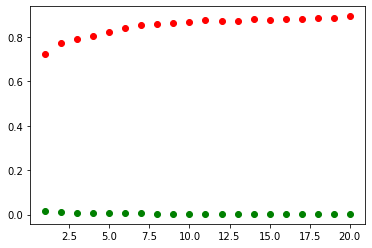


Test Accuracy = 0.862

Total time taken (in seconds): 318.11
-------------------------- Run: 1 --------------------------------

Train Accuracy: 0.7215
Number of Epoch = 1 - Average Cross Entropy:= 0.01491559814453125 

Validation Accuracy: 0.7172

Train Accuracy: 0.7566
Number of Epoch = 2 - Average Cross Entropy:= 0.010751910400390625 

Validation Accuracy: 0.7514

Train Accuracy: 0.7836
Number of Epoch = 3 - Average Cross Entropy:= 0.008423291625976562 

Validation Accuracy: 0.7757

Train Accuracy: 0.8002
Number of Epoch = 4 - Average Cross Entropy:= 0.007009253540039062 

Validation Accuracy: 0.7918

Train Accuracy: 0.7932
Number of Epoch = 5 - Average Cross Entropy:= 0.006066343383789062 

Validation Accuracy: 0.7879

Train Accuracy: 0.8407
Number of Epoch = 6 - Average Cross Entropy:= 0.005439669799804687 

Validation Accuracy: 0.8348

Train Accuracy: 0.8545
Number of Epoch = 7 - Average Cross Entropy:= 0.004899909057617187 

Validation Accuracy: 0.8471

Train Accuracy: 0.8590
N

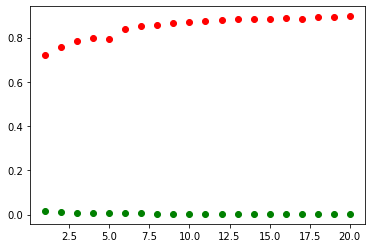


Test Accuracy = 0.8677

Total time taken (in seconds): 266.19
-------------------------- Run: 2 --------------------------------

Train Accuracy: 0.6724
Number of Epoch = 1 - Average Cross Entropy:= 0.015303988037109376 

Validation Accuracy: 0.6685

Train Accuracy: 0.7152
Number of Epoch = 2 - Average Cross Entropy:= 0.01152932373046875 

Validation Accuracy: 0.7090

Train Accuracy: 0.7457
Number of Epoch = 3 - Average Cross Entropy:= 0.00921582275390625 

Validation Accuracy: 0.7420

Train Accuracy: 0.7822
Number of Epoch = 4 - Average Cross Entropy:= 0.007709140014648438 

Validation Accuracy: 0.7726

Train Accuracy: 0.7997
Number of Epoch = 5 - Average Cross Entropy:= 0.006697489624023437 

Validation Accuracy: 0.7931

Train Accuracy: 0.8193
Number of Epoch = 6 - Average Cross Entropy:= 0.005967528686523438 

Validation Accuracy: 0.8120

Train Accuracy: 0.8393
Number of Epoch = 7 - Average Cross Entropy:= 0.005394259643554687 

Validation Accuracy: 0.8318

Train Accuracy: 0.8504
N

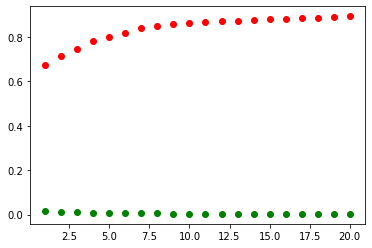


Test Accuracy = 0.8619

Total time taken (in seconds): 266.19
Test Accuracy [0.862, 0.8677, 0.8619]
the mean of 3 runs is 0.8638666666666667, and the variance is 7.3488888888889725e-06


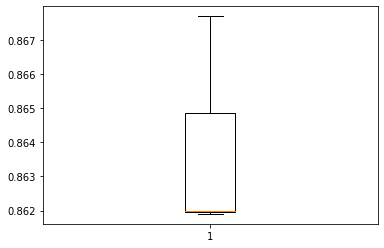

In [10]:
# Set number of epochs
NUM_EPOCHS = 20


test_acc_total = []

# Initialize model using CPU
time_start = time.time()
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)

for i in range(3):
  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
  time_start = time.time()
  print('-------------------------- Run:', i, '--------------------------------')

  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs, True) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, optimizer)

    preds = mlp_on_cpu.forward(X_train, True)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    preds_val = mlp_on_cpu.forward(X_val, True)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, ds, 'ro', label = 'accuracy')
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go', label = 'loss')

  plt.show()        
  time_taken = time.time() - time_start
    
    
  # Test Accuracy of Model in each iteration
  preds = mlp_on_cpu.forward(X_test, False)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred == y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
   

test_mean = np.mean(test_acc_total)
test_var = np.var(test_acc_total)
print('Test Accuracy', test_acc_total)
print(f"the mean of 3 runs is {test_mean}, and the variance is {test_var}")
plt.boxplot(test_acc_total)
plt.show()

**Model 2: Pre Activation. Performing Batch Normalization before Activation Function** 

In [11]:
# Define class to build mlp model
class MLP(tf.keras.Model):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    super(MLP, self).__init__()
    
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.batchnorm = BNLayer(128)
    self.mlp_variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X, is_training):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X, is_training = is_training)
    else:
      self.y = self.compute_output(X, is_training = is_training)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

   
 def backward(self, X_train, y_train, optimizer):
    """
    backward pass
    """
    optimizer = optimizer
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train, True)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.mlp_variables)
    optimizer.apply_gradients(zip(grads, self.mlp_variables))

           
 def compute_output(self, X, is_training):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    z1 = self.batchnorm(z1, is_training)
    h1 = tf.nn.relu(z1)

    z2 = tf.matmul(h1, self.W2) + self.b2
    z2 = self.batchnorm(z2, is_training)
    h2 = tf.nn.relu(z2)

    
    z3 = tf.matmul(h2, self.W3) + self.b3
    z3 = self.batchnorm(z3, is_training)
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


**Three Runs to check how the accuracy changes in each iteration**

-------------------------- Run: 0 -----------------------------------------

Train Accuracy: 0.6000
Number of Epoch = 1 - Average Cross Entropy:= 0.01667481689453125 

Validation Accuracy: 0.5978

Train Accuracy: 0.6600
Number of Epoch = 2 - Average Cross Entropy:= 0.0142249462890625 

Validation Accuracy: 0.6577

Train Accuracy: 0.7326
Number of Epoch = 3 - Average Cross Entropy:= 0.012232149658203125 

Validation Accuracy: 0.7288

Train Accuracy: 0.7763
Number of Epoch = 4 - Average Cross Entropy:= 0.0106680859375 

Validation Accuracy: 0.7736

Train Accuracy: 0.7921
Number of Epoch = 5 - Average Cross Entropy:= 0.009417753295898437 

Validation Accuracy: 0.7878

Train Accuracy: 0.8088
Number of Epoch = 6 - Average Cross Entropy:= 0.00840052490234375 

Validation Accuracy: 0.8021

Train Accuracy: 0.8252
Number of Epoch = 7 - Average Cross Entropy:= 0.007564212036132813 

Validation Accuracy: 0.8180

Train Accuracy: 0.8360
Number of Epoch = 8 - Average Cross Entropy:= 0.00687433410644

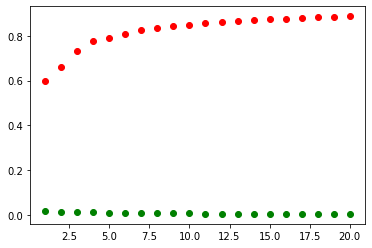


Test Accuracy = 0.8625

Total time taken (in seconds): 276.42
-------------------------- Run: 1 -----------------------------------------

Train Accuracy: 0.6847
Number of Epoch = 1 - Average Cross Entropy:= 0.016531710205078126 

Validation Accuracy: 0.6783

Train Accuracy: 0.7295
Number of Epoch = 2 - Average Cross Entropy:= 0.0136441015625 

Validation Accuracy: 0.7242

Train Accuracy: 0.7520
Number of Epoch = 3 - Average Cross Entropy:= 0.01119015380859375 

Validation Accuracy: 0.7476

Train Accuracy: 0.7753
Number of Epoch = 4 - Average Cross Entropy:= 0.009409397583007812 

Validation Accuracy: 0.7689

Train Accuracy: 0.7914
Number of Epoch = 5 - Average Cross Entropy:= 0.008159282836914063 

Validation Accuracy: 0.7856

Train Accuracy: 0.8028
Number of Epoch = 6 - Average Cross Entropy:= 0.007255148315429688 

Validation Accuracy: 0.7982

Train Accuracy: 0.8133
Number of Epoch = 7 - Average Cross Entropy:= 0.0065685595703125 

Validation Accuracy: 0.8082

Train Accuracy: 0.826

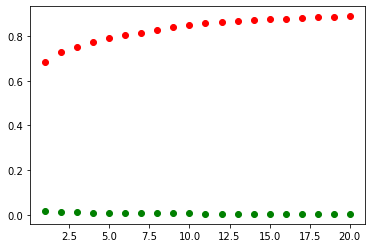


Test Accuracy = 0.8638

Total time taken (in seconds): 272.72
-------------------------- Run: 2 -----------------------------------------

Train Accuracy: 0.6308
Number of Epoch = 1 - Average Cross Entropy:= 0.01635863525390625 

Validation Accuracy: 0.6306

Train Accuracy: 0.6657
Number of Epoch = 2 - Average Cross Entropy:= 0.013340413818359376 

Validation Accuracy: 0.6621

Train Accuracy: 0.7018
Number of Epoch = 3 - Average Cross Entropy:= 0.010990416259765625 

Validation Accuracy: 0.6986

Train Accuracy: 0.7348
Number of Epoch = 4 - Average Cross Entropy:= 0.009355374755859375 

Validation Accuracy: 0.7294

Train Accuracy: 0.7577
Number of Epoch = 5 - Average Cross Entropy:= 0.0081945263671875 

Validation Accuracy: 0.7518

Train Accuracy: 0.7856
Number of Epoch = 6 - Average Cross Entropy:= 0.0073208551025390626 

Validation Accuracy: 0.7764

Train Accuracy: 0.8114
Number of Epoch = 7 - Average Cross Entropy:= 0.006632061157226562 

Validation Accuracy: 0.8083

Train Accuracy:

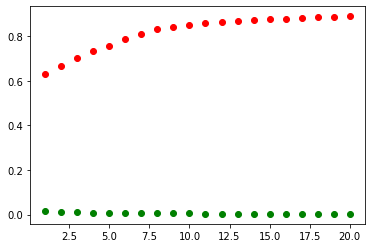


Test Accuracy = 0.8648

Total time taken (in seconds): 268.76
Test Accuracy [0.8625, 0.8638, 0.8648]
the mean of 3 runs is 0.8637, and the variance is 8.866666666666416e-07


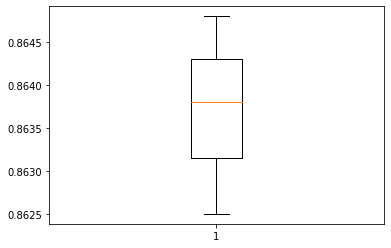

In [12]:
# Set number of epochs
NUM_EPOCHS = 20


test_acc_total = []

# Initialize model using CPU
time_start = time.time()
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)

for i in range(3):

  mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
  time_start = time.time()
  print('-------------------------- Run:', i, '-----------------------------------------')

  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(inputs, True) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs, optimizer)

    preds = mlp_on_cpu.forward(X_train, True)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    preds_val = mlp_on_cpu.forward(X_val, True)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, ds, 'ro', label = 'accuracy')
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go', label = 'loss')

  plt.show()        
  time_taken = time.time() - time_start
    
  # Test Accuracy of Model in each iteration
  preds = mlp_on_cpu.forward(X_test, False)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred == y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
   

test_mean = np.mean(test_acc_total)
test_var = np.var(test_acc_total)
print('Test Accuracy', test_acc_total)
print(f"the mean of 3 runs is {test_mean}, and the variance is {test_var}")
plt.boxplot(test_acc_total)
plt.show()
